In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models, matutils
import numpy as np
import pickle

In [2]:
movie_data = pd.read_json('../data/movies_cleaned.json')

In [7]:
movie_data.to_excel('../data/movies_cleaned.xls',index = False)

In [3]:
gl = ['Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy',
 'Film-Noir','History','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western',]

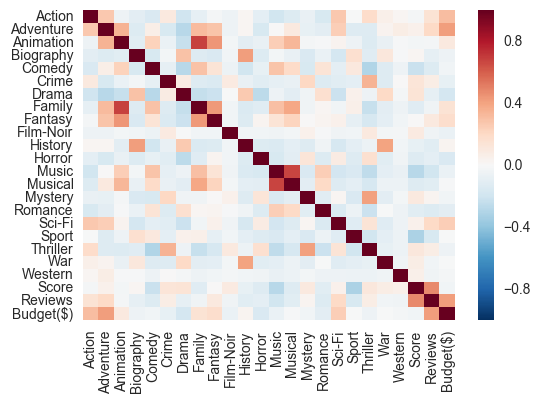

In [4]:
gl = gl+['Score','Reviews','Budget($)']
sns.heatmap(movie_data[gl].corr())
# Budget does not have a strong correlation with Socre

In [90]:
pd.DataFrame(movie_data[gl].corr()['Score']).sort_values('Score', ascending=False)[1:11]

,Score
Reviews,0.477471
Drama,0.134212
Crime,0.126301
Thriller,0.112050
Mystery,0.099512
Film-Noir,0.088142
War,0.072312
Western,0.056828
Adventure,0.050468
Sci-Fi,0.048031


In [229]:
df2 = pd.DataFrame(columns=["genre",'movies'])
for i in gl[:-3]:
    df2 = df2.append({'genre':i,'movies':sum(df[i])}, ignore_index=True)

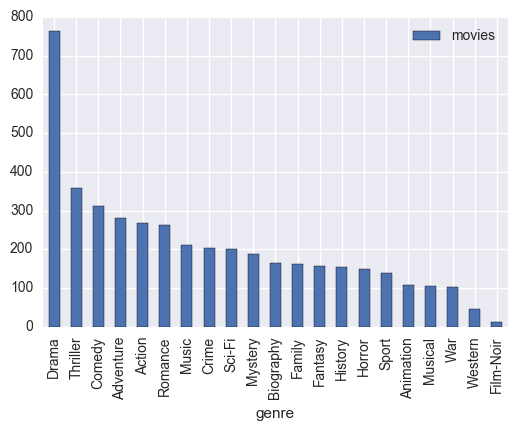

In [236]:
df2.sort_values('movies',ascending = False).reset_index(drop = True).plot(kind = 'bar',x='genre',y = 'movies')

In [242]:
df2 = pd.DataFrame(columns=["genre",'avg score'])
for i in gl[:-3]:
    df2 = df2.append({'genre':i,'avg score':np.mean(df[df[i] ==1]['Score'])}, ignore_index=True)

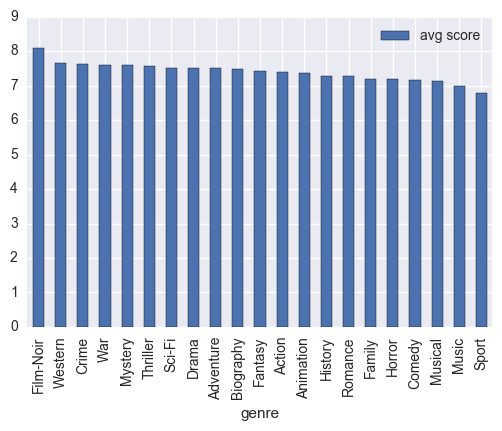

In [244]:
df2.sort_values('avg score',ascending = False).reset_index(drop = True).plot(kind = 'bar',x='genre',y = 'avg score')

In [12]:
vectorizer = CountVectorizer(ngram_range=(2,4),stop_words='english',max_df=.5)

X = vectorizer.fit_transform(movie_data.Storyline)
X.todense()

vocab2 = {v: k for k, v in vectorizer.vocabulary_.iteritems()}

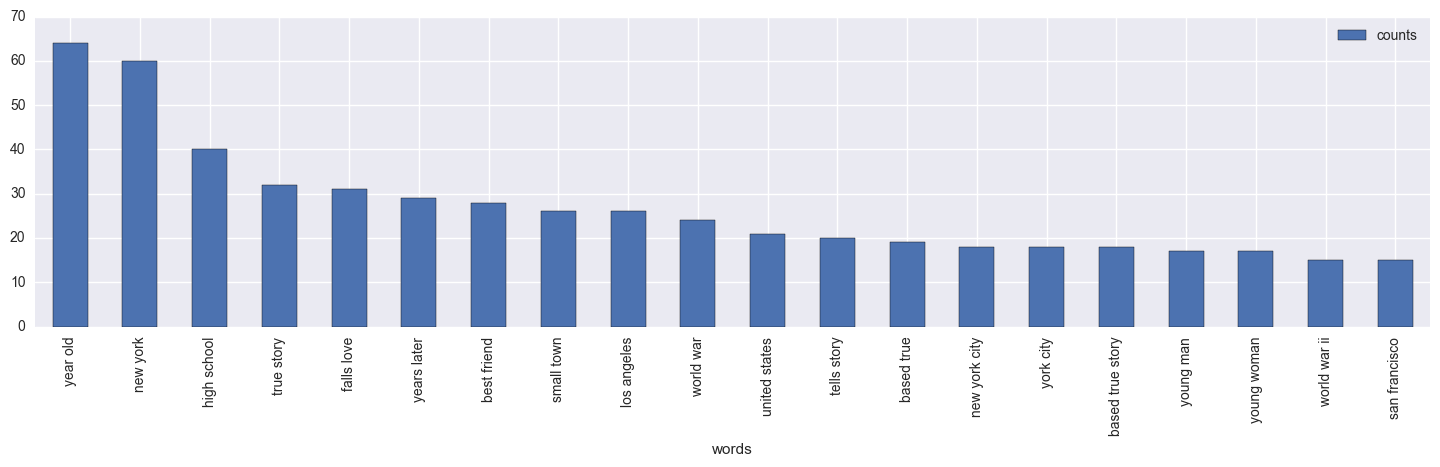

In [22]:
words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
word_count = words.sum(axis=0).reset_index()
word_count.columns = ['words','counts']
word_count.sort_values('counts', ascending=False, inplace=True)
word_count.head(20).plot(x='words', y='counts', kind='bar', figsize=(18,4))

In [91]:
lda2 = models.LdaModel(
   matutils.Sparse2Corpus(X, documents_columns=False),
   num_topics  =  10,
   passes      =  100,
   iterations = 2500,
   id2word     =  vocab2,
   eval_every = 100,
   chunksize = 2000
)

for e,i in enumerate(lda2.print_topics()):
    print "\nTopic " + str(e+1)
    print i


Topic 1
(0, u'0.000*"new york" + 0.000*"year old" + 0.000*"high school" + 0.000*"best friend" + 0.000*"true story" + 0.000*"tells story" + 0.000*"sister aloysius" + 0.000*"young man" + 0.000*"true love" + 0.000*"young woman"')

Topic 2
(1, u'0.000*"new york" + 0.000*"los angeles" + 0.000*"year old" + 0.000*"falls love" + 0.000*"years later" + 0.000*"best friend" + 0.000*"high school" + 0.000*"young man" + 0.000*"rio janeiro" + 0.000*"world war"')

Topic 3
(2, u'0.000*"martial arts" + 0.000*"san francisco" + 0.000*"high school" + 0.000*"small town" + 0.000*"new york" + 0.000*"jong goo" + 0.000*"du pont" + 0.000*"crown prince" + 0.000*"based true" + 0.000*"real life"')

Topic 4
(3, u'0.000*"year old" + 0.000*"new york" + 0.000*"years later" + 0.000*"united states" + 0.000*"world war" + 0.000*"falls love" + 0.000*"best friend" + 0.000*"new york city" + 0.000*"york city" + 0.000*"prince john"')

Topic 5
(4, u'0.000*"high school" + 0.000*"new york" + 0.000*"true story" + 0.000*"based true 

In [24]:
bow = []
blank_documents = 0

for document in X.toarray():

    single_document = []

    for token_id, token_count in enumerate(document):
        
        if token_count > 0:
              single_document.append((token_id, token_count))
            
    if len(single_document)>0:
        bow.append(single_document)
    else:
        blank_documents += 1
        bow.append([])

In [25]:
topic_proba =lda2.get_document_topics(bow)

In [28]:
# put topic prob into dataframe
topic_df = np.zeros((len(topic_proba), 10))
for rowid, tp in enumerate(topic_proba):
    for colid, p in tp:
        topic_df[rowid, colid] = p
        
topic_df = pd.DataFrame(topic_df, columns=['t'+str(i+1) for i in range(topic_df.shape[1])])

In [79]:
topic_df['max_topic'] = topic_df.idxmax(axis=1)
topic_df['max_prob'] =  topic_df[topic_df.columns[:10]].apply(np.max, axis=1)

In [373]:
# topic_df.groupby('max_topic')['t1'].count().reset_index().rename(columns = {'t1':'count'}).sort_values('count',ascending = False)

In [375]:
# df.groupby('max_topic')['Score'].mean().reset_index().rename(columns = {'Score':'Avg Score'}).sort_values('Avg Score',ascending = False)

In [376]:
# topic_df['max_prob'].hist()

In [226]:
df = pd.concat([movie_data, topic_df], axis=1)

In [227]:
df = df[df['Action'].isnull() == False]

In [377]:
# pd.DataFrame(df.corr()['Score']).sort_values('Score', ascending=False).reset_index()[1:11]

In [378]:
# df3.columns = ['Field','Corr with Score']

In [379]:
# df3[df3['Field'].isin(list(topic_df.columns))].reset_index(drop = True)

In [380]:
# df[['Title'] + list(topic_df.columns)].head()

In [353]:
pb = df[df['Title'] == df['Title'][0]]
x = ['Title', 'Score', 'Reviews', 'Budget($)', 'Directors','Writers','Stars', 'Genres2','max_topic']
for c in x:
    print c,": ",pb[c][0]
#     print c + ": " + str(pb[c][0])

Title :  Point Break 
Score :  5.3
Reviews :  49433.0
Budget($) :  105000000.0
Directors :  Ericson Core
Writers :  Kurt Wimmer,Rick King
Stars :  Edgar Ram?rez,Luke Bracey,Ray Winstone
Genres2 :   Action, Crime, Sport, Thriller
max_topic :  t2


In [398]:
import pickle

In [399]:
filename = 'LDA_model.sav'
pickle.dump(lda2, open(filename, 'wb'))

In [ ]:
# lda2 = pickle.load(open('LDA_model.sav', 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)